In [11]:
import os
import numpy as np
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import functional as TVF
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import ConcatDataset
from sklearn.metrics import precision_score, recall_score, f1_score
import random



device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


############################
- Coded by Wong Wai Chun
############################

In [2]:
data_dir = "MY_data"

aug1 = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug2 = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug3 = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

original_dataset = ImageFolder(data_dir + "/train", transform=aug1)

augmented_datasets = [
    ImageFolder(data_dir + "/train", transform=aug1),
    ImageFolder(data_dir + "/train", transform=aug2),
    ImageFolder(data_dir + "/train", transform=aug3)
]

full_dataset = ConcatDataset([original_dataset] + augmented_datasets)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

testset = ImageFolder(data_dir + "/Test", transform=test_transform)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

class_names = original_dataset.classes
num_classes = len(class_names)
print(f'Number of classes: {class_names}')
print(f'Number of classes: {num_classes}')
print(f'Number of images in  trainset: {len(full_dataset)}')

Number of classes: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Number of classes: 10
Number of images in  trainset: 9204


############################
- Coded by Webster Wang Wei Yang
############################

In [3]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()


############################
- Adapted from Practical_6
############################

In [4]:
def train(net, trainloader, valloader, device, num_epochs, lr=0.01, weight_decay = 0.8, step_size = 5, gamma = 0.1):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    net = net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        running_loss = 0
        running_corrects = 0
        total_samples = 0

        net.train() 
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            total_samples += inputs.size(0)

        train_loss = running_loss / total_samples
        train_acc = running_corrects.float() / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.cpu().numpy())

        net.eval()  
        val_loss = 0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad(): 
            for inputs, labels in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
                val_samples += inputs.size(0)

        val_loss /= val_samples
        val_acc = val_corrects.double() / val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.cpu().numpy())

        print(f'[Epoch {epoch+1:2d}]: train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, '
              f'validation_loss = {val_loss:.4f}, validation_acc = {val_acc:.4f}')

        scheduler.step() 

    print("Training completed.")
    return train_losses, val_losses, train_accuracies, val_accuracies

############################
- Coded by Wong Wai Chun
############################

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(p=0.5)  
        
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(128, 10)  
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        
        x = self.dropout_conv(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


net = CNN()
summary(net, input_size=(64, 3, 40, 40))


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 40, 40]          448
├─Conv2d: 1-2                            [64, 32, 40, 40]          4,640
├─BatchNorm2d: 1-3                       [64, 32, 40, 40]          64
├─MaxPool2d: 1-4                         [64, 32, 20, 20]          --
├─Conv2d: 1-5                            [64, 64, 20, 20]          18,496
├─Conv2d: 1-6                            [64, 128, 20, 20]         73,856
├─BatchNorm2d: 1-7                       [64, 128, 20, 20]         256
├─MaxPool2d: 1-8                         [64, 128, 10, 10]         --
├─Dropout: 1-9                           [64, 128, 10, 10]         --
├─AdaptiveAvgPool2d: 1-10                [64, 128, 1, 1]           --
├─Linear: 1-11                           [64, 10]                  1,290
Total params: 99,050
Trainable params: 99,050
Non-trainable params: 0

In [6]:
train_losses, val_losses, train_accuracies, val_accuracies = train(net, train_loader, val_loader, device, num_epochs = 30, lr = 0.001, weight_decay = 1e-4,step_size = 10, gamma = 0.8)

[Epoch  1]: train_loss = 1.7575, train_acc = 0.3955, validation_loss = 1.6531, validation_acc = 0.4237
[Epoch  2]: train_loss = 1.4970, train_acc = 0.5052, validation_loss = 1.4044, validation_acc = 0.5263
[Epoch  3]: train_loss = 1.3473, train_acc = 0.5515, validation_loss = 1.3249, validation_acc = 0.5774
[Epoch  4]: train_loss = 1.2407, train_acc = 0.5892, validation_loss = 1.2012, validation_acc = 0.6095
[Epoch  5]: train_loss = 1.1370, train_acc = 0.6204, validation_loss = 1.2210, validation_acc = 0.6089
[Epoch  6]: train_loss = 1.0619, train_acc = 0.6488, validation_loss = 1.1087, validation_acc = 0.6442
[Epoch  7]: train_loss = 1.0099, train_acc = 0.6630, validation_loss = 1.0100, validation_acc = 0.6524
[Epoch  8]: train_loss = 0.9404, train_acc = 0.6932, validation_loss = 1.0270, validation_acc = 0.6605
[Epoch  9]: train_loss = 0.8832, train_acc = 0.7057, validation_loss = 0.9609, validation_acc = 0.6757
[Epoch 10]: train_loss = 0.8433, train_acc = 0.7189, validation_loss = 0.

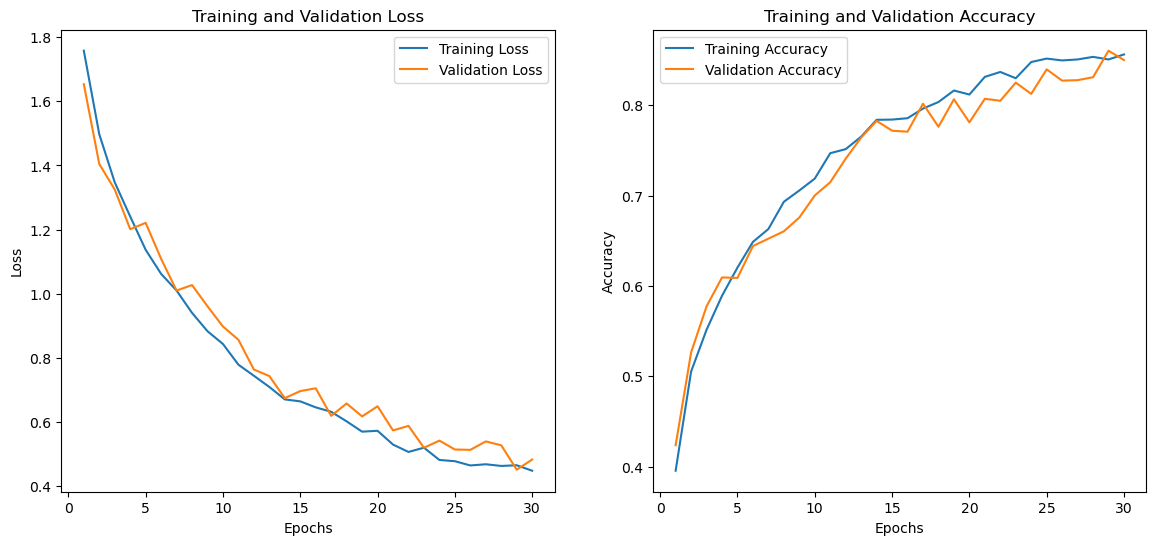

In [7]:
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [8]:
torch.save(net, 'model.pth')

############################
- Adapted from Practical_6
############################

In [15]:
def evaluate(net, dataloader, device):
    net.eval() 
    all_targets = []
    all_predictions = []

    with torch.no_grad(): 
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1) 
            
            all_targets.extend(targets.cpu().numpy())  
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
    print(f'Accuracy: {accuracy:.4f}')

    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    return accuracy, precision, recall, f1


In [16]:
net = torch.load('model.pth')
evaluate(net, test_loader, device)

Accuracy: 0.7795
Precision: 0.7834
Recall: 0.7795
F1-Score: 0.7776


(0.7795121951219512, 0.783353040610202, 0.7795121951219512, 0.777606108846864)

############################
- Coded by Webster Wang Wei Yang
############################

In [17]:
def predict_image(image_path, model):
    model.eval()
    
    device = next(model.parameters()).device
    
    image = Image.open(image_path)

    predict_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = predict_transform(image)
    
    img = img.to(device)
    
    xb = img.unsqueeze(0)
    
    with torch.no_grad():
        yb = model(xb)
        
    _, preds = torch.max(yb, dim=1)
    
    return preds.item()

############################
- Coded by Wong Wai Chun
############################

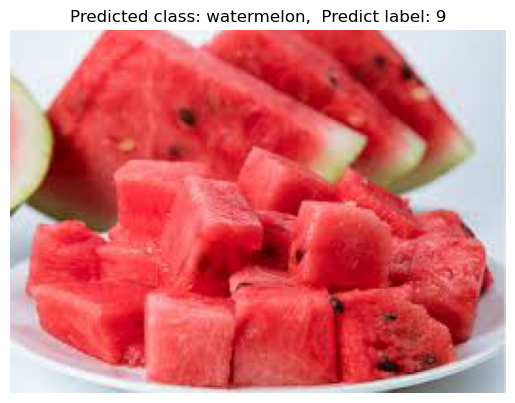

In [18]:
def display_image_with_prediction(image_path, model):
    pred_class_idx = predict_image(image_path, model)
    
    pred_class = class_names[pred_class_idx]
    
    image = Image.open(image_path)
    plt.imshow(image)
    pred_class_idx
    plt.title(f"Predicted class: {pred_class},  Predict label: {pred_class_idx}")
    plt.axis('off') 
    plt.show()

image_path = data_dir + "/predict/012.jpeg" 
display_image_with_prediction(image_path, net)  